In [40]:
# Find a different format to store and query this kind of information.

import json
from pathlib import Path

d = {}

for f in Path("./d").glob("*.json"):
    d[f.stem] = json.load(open(f))

from pymongo import MongoClient

client = MongoClient()
client.drop_database("factorio")
db = client.factorio

del d["active_mods"]
for k, vs in d.items():
    for v in vs.values():
        db[k.replace("-", "_")].insert_one(dict(**v, **{"_id":v['name']}))


In [41]:
import builder

g = builder.HyperDiGraph()

for r in db.recipe.find({"hidden": False}):
    query = {f"crafting_categories.{r['category']}": {"$exists": True}, "name": {"$nin": ["kr-crash-site-assembling-machine-1-repaired", "kr-crash-site-assembling-machine-2-repaired"]}}
    for m in [m for m in db.assembling_machine.find(query)] + [m for m in db.furnace.find(query)]:
        
        if m["name"] in {"kr-advanced-assembling-machine", 'kr-advanced-chemical-plant', 'kr-advanced-furnace', "steel-furnace", "kr-matter-plant"}:
            continue

        A = {i["name"] for i in r["ingredients"]}
        B = {p["name"] for p in r["products"]}
        g.add_edge(A, B, {"recipe": r, "machine": m, "name": f"{r['name']}#{m['name']}"})

# display(next(iter(g.edges_data())))

In [42]:
import mip

def compute_cost(data):
    return 1 # data["machine"]["energy_usage"]

def ingredient_coef(data, v):
    coef = data["machine"]["crafting_speed"] * sum(i["amount"] for i in data["recipe"]["ingredients"] if i["name"] == v) / data["recipe"]["energy"]
    assert coef > 0
    return coef

def product_coef(data, v):
    try:
        coef = data["machine"]["crafting_speed"] * sum(p["amount"]*p["probability"] for p in data["recipe"]["products"] if p["name"] == v) / data["recipe"]["energy"]
    except:
        coef = data["machine"]["crafting_speed"] * sum((p["amount_min"] + p["amount_max"])/2*p["probability"] for p in data["recipe"]["products"] if p["name"] == v) / data["recipe"]["energy"]
    assert coef > 0
    return coef

def build_model(graph, sources):
    model = mip.Model()

    flow_int = {data["name"]: model.add_var(f"flow_{data['name']}", lb=0, obj=compute_cost(data), var_type=mip.INTEGER) for a, b, data in graph.edges_data()}
    flow = {data["name"]: model.add_var(f"flow_{data['name']}", lb=0, obj=compute_cost(data)) for a, b, data in graph.edges_data()}
    
    for _, _, d in graph.edges_data():
        model.add_constr(flow[d["name"]] <= flow_int[d["name"]])
    
    diffs = {}    
    produced = {}
    used = {}
    
    
    considered = {}
    
    fluids = {f["name"] for f in db.fluid.find({})}

    for v in graph.nodes():
        
        diff = mip.quicksum(flow[data["name"]] * ingredient_coef(data, v) for (_, _, data) in graph.out_edges_data(v)) - mip.quicksum(flow[data["name"]] * product_coef(data, v) for (_, _, data) in graph.in_edges_data(v))
        diffs[v] = diff
        
        considered[v] = mip.quicksum(flow[data["name"]] * ingredient_coef(data, v) for (_, _, data) in graph.out_edges_data(v)) + mip.quicksum(flow[data["name"]] * product_coef(data, v) for (_, _, data) in graph.in_edges_data(v))
        
        
        for (_, _, data) in graph.in_edges_data(v):
            used[v, data["name"]] = flow[data["name"]] * product_coef(data, v)
        
        for (_, _, data) in graph.out_edges_data(v):
            produced[v, data["name"]] = flow[data["name"]] * ingredient_coef(data, v)
        
        # model.objective = model.objective - diff
        
        if v in sources:
            model.add_constr(diff <= sources[v])
        elif v in fluids:
            model.add_constr(diff == 0)
        else:
            model.add_constr(diff <= 0)

    model.optimize()
    print(model.status)

    return(
        {k: v.x for k, v in diffs.items() if v.x is not None and v.x != 0},
        {k for k, v in considered.items() if v.x is not None and v.x != 0},
        {k: v.x for k, v in used.items() if v.x is not None and v.x != 0},
        {k: v.x for k, v in produced.items() if v.x is not None and v.x != 0},
        {k: v.x for k, v in flow.items() if v.x is not None and v.x > 0},
        {k: v.x for k, v in flow_int.items() if v.x is not None and int(v.x) > 0},
    )

In [43]:
import networkx as nx

from collections import defaultdict

import copy
from collections import deque

def rolling(it, k=2):
    q = deque(maxlen=k)
    it = iter(it)
    
    for _ in range(k):
        q.append(next(it))
    
    yield tuple(q)

    for x in it:
        q.append(x)
        yield tuple(q)
    
    

dag = nx.DiGraph({t['_id']: t['prerequisites'] for t in db.technology.find()})

list(nx.topological_sort(dag))

order = {k: i for i, k in enumerate([
    'basic-tech-card',
    'automation-science-pack',
    'logistic-science-pack',
    'military-science-pack',
    'chemical-science-pack',
    'production-science-pack',
    'utility-science-pack',
    'matter-tech-card',
    
    'advanced-tech-card',
    'space-science-pack',
    'singularity-tech-card',
])}

tierlist = defaultdict(list)
for t in db.technology.find():
    for e in t['effects']:
        if e["type"] == "unlock-recipe":
            tierlist[max((i["name"] for i in t["research_unit_ingredients"]), key=order.get)].append(e["recipe"])

tierlist = dict(tierlist)




tierlist_cum = {k: set(v) for k, v in tierlist.items()}
for k1, k2 in rolling(order):
    tierlist_cum[k2] |= tierlist_cum[k1]

assert len(tierlist_cum.keys()) == len(tierlist.keys())


In [44]:
list(db.recipe.find({"_id": "kovarex-enrichment-process"}))

[{'_id': 'kovarex-enrichment-process',
  'name': 'kovarex-enrichment-process',
  'localised_name': ['recipe-name.kovarex-enrichment-process'],
  'category': 'centrifuging',
  'order': 'r[uranium-processing]-c[kovarex-enrichment-process]',
  'group': {'name': 'intermediate-products', 'type': 'item-group'},
  'subgroup': {'name': 'intermediate-product', 'type': 'item-subgroup'},
  'enabled': False,
  'hidden': False,
  'hidden_from_player_crafting': False,
  'emissions_multiplier': 1,
  'energy': 60,
  'ingredients': [{'type': 'item',
    'name': 'uranium-235',
    'amount': 30,
    'catalyst_amount': 30},
   {'type': 'item', 'name': 'uranium-238', 'amount': 3}],
  'products': [{'type': 'item',
    'name': 'uranium-235',
    'probability': 1,
    'amount': 31,
    'catalyst_amount': 30},
   {'type': 'item', 'name': 'stone', 'probability': 1, 'amount': 2}]}]

In [45]:
# Semantic decomposition of items using recipes.

grouped = []
for r in db.recipe.find({"hidden": False}):
    if "main_product" in r:
        grouped.append(((r["group"]["name"], (r["subgroup"]["name"], r["main_product"]["name"]))))

from collections import defaultdict
gg = defaultdict(lambda: defaultdict(set))
for r in db.recipe.find({"hidden": False}):
    if "main_product" in r:
        gg[r["group"]["name"]][r["subgroup"]["name"]].add(r["main_product"]["name"])

grouped = sorted(grouped)


from functools import reduce
import operator

bli = reduce(operator.or_, [gg['combat'][k] for k in gg["combat"] if k not in {"equipment", 'armor', 'gun', 'vehicle-motor', 'character-equipment', 'radars-and-rockets', 'capsule'}])
# gg["intermediate-products"]["fuild"]

# display(gg["production"]["energy"])

# bli 

# [(k1, k2, len(v2)) for k1, v1 in gg.items() for k2, v2 in v1.items()]

In [46]:
# flows, config = build_model(g, {"iron-ore": float("+inf"), "crude-oil": float("+inf"),"copper-ore": float("+inf"), "assembling-machine-3": -1})

source = {
    "iron-ore": float("+inf"),
    "crude-oil": float("+inf"),
    "copper-ore": float("+inf"),
    "stone": float("+inf"),
    "coal": float("+inf"),
    "watter": float("+inf"),
    "wood": float("+inf"),
    "brick": float("+inf"),
    "steel-plate": float("+inf"),
    "plastic": float("+inf"),
    "advanced-tech-card": -1,
}

bli = gg['production']['module'] | gg['production']['production-machine'] | gg['production']['extraction-machine'] | gg['production']['smelting-machine'] | gg['production']['tool']

bli = bli - {"kr-singularity-beacon", "kr-electric-mining-drill-mk3", "stone-furnace", "steel-furnace", "kr-advanced-assembling-machine", "kr-advanced-furnace", "kr-matter-plant#assembling-machine-3", "kr-matter-assembler#assembling-machine-3", "kr-stabilizer-charging-station", }
bli = bli - {'effectivity-module', 'effectivity-module-2', 'effectivity-module-3', 'speed-module', 'speed-module-2', 'speed-module-3', 'productivity-module',  'productivity-module-2',  'productivity-module-3'}
bla = gg['intermediate-products']['raw-material'] | gg['intermediate-products']['fluid-recipes'] | gg['intermediate-products']['raw-resource'] | gg['intermediate-products']['fill-barrel'] | {"iron-ore", "stone"}


source = dict(**{k: -1/1000 for k in bli}, **{k: float("+inf") for k in bla})
# source = {
#     "stone": float("+inf"),
#     "water": float("+inf"),
#     "glass": -15,
#     "quartz": -15,
#     "silicon": -15,
#     "chlorine": -15,
#     "stone-brick": -15,
# }

# source = {
#     "iron-ore": float("+inf"),
#     "crude-oil": float("+inf"),
#     "copper-ore": float("+inf"),
#     "stone": float("+inf"),
#     "coal": float("+inf"),
#     "water": float("+inf"),
#     "wood": float("+inf"),
#     "brick": float("+inf"),
#     "oil": float("+inf"),
#     "steel-plate": float("+inf"),
#     "plastic": float("+inf"),
#     "raw-rare-metals": float("+inf"),
#     "chlorine"
# flows, config = build_model(g, {"iron-ore": float("+inf"), "crude-oil": float("+inf"),"copper-ore": float("+inf"), "assembling-machine-3": -1})

source = {
    "iron-ore": float("+inf"),
    "crude-oil": float("+inf"),
    "copper-ore": float("+inf"),
    "stone": float("+inf"),
    "coal": float("+inf"),
    "watter": float("+inf"),
    "wood": float("+inf"),
    "brick": float("+inf"),
    "steel-plate": float("+inf"),
    "plastic": float("+inf"),
    "advanced-tech-card": -1,
}

bli = gg['production']['module'] | gg['production']['production-machine'] | gg['production']['extraction-machine'] | gg['production']['smelting-machine'] | gg['production']['tool']

# bli = bli - {"kr-singularity-beacon", "kr-electric-mining-drill-mk3", "stone-furnace", "steel-furnace", "kr-advanced-assembling-machine", "kr-advanced-furnace", "kr-matter-plant", "kr-matter-assembler", "kr-stabilizer-charging-station", "burner-mining-drill"}

# no modules
bli = bli - {'effectivity-module', 'effectivity-module-2', 'effectivity-module-3', 'speed-module', 'speed-module-2', 'speed-module-3', 'productivity-module',  'productivity-module-2',  'productivity-module-3'}




bla = gg['intermediate-products']['raw-material'] | gg['intermediate-products']['fluid-recipes'] | gg['intermediate-products']['raw-resource']#  | gg['intermediate-products']['fill-barrel']

# bla = reduce(operator.or_, gg["intermediate-products"].values())
bla = bla | {"iron-ore", "stone", "uranium-238", "uranium-235"}
bla = bla | {"electric-engine-unit"}

bla = bla | {"mineral-water", "water", "hydrogen", "nitrogen", "raw-imersite", 'petroleum-gas'}

bla -= {"imersium-plate", "nitric-acid", "imersite-powder", "ammonia", "lithium-sulfur-battery"}
bla -= {"nitric-acid-barrel", "mineral-water-barrel", "sulfuric-acid", "lithium-chloride", "sulfur"}


soft = reduce(operator.or_, [gg['combat'][k] for k in ["equipment", 'armor', 'gun', 'vehicle-motor', 'character-equipment']])
bli = reduce(operator.or_, [gg['combat'][k] for k in gg["combat"] if k not in {'radars-and-rockets', 'capsule'}])

# bla = {"water", "coke", "steam"}

#bbli = {'petroleum-gas'}


# source = {"biomethanol": - 6 * 36 * 3, "steam": float("+inf"), "water": float("+inf") }


# bla = {"copper-plate", "iron-plate"}
# bli = {""}
# source = 



source = dict(**{k: -1/100000 if k in soft else -1/60 for k in bli}, **{k: float("+inf") for k in bla})



source = {""}
# source = {
#     "stone": float("+inf"),
#     "water": float("+inf"),
#     "glass": -15,
#     "quartz": -15,
#     "silicon": -15,
#     "chlorine": -15,
#     "stone-brick": -15,
# }

# source = {
#     "iron-ore": float("+inf"),
#     "crude-oil": float("+inf"),
#     "copper-ore": float("+inf"),
#     "stone": float("+inf"),
#     "coal": float("+inf"),
#     "water": float("+inf"),
#     "wood": float("+inf"),
#     "brick": float("+inf"),
#     "oil": float("+inf"),
#     "steel-plate": float("+inf"),
#     "plastic": float("+inf"),
#     "raw-rare-metals": float("+inf"),
#     "chlorine": -30
# }
# source = {k: -100 for k in gg['intermediate-products']['science-pack']}




source = dict(
    **{
        # "kr-fusion-reactor":-1/600,
        # "kr-advanced-steam-turbine":-1/10
        "kr-matter-assembler": -1/60,
        "kr-matter-plant": -1/60,
    },
    
    **{
        # 'production-science-pack': -1/2,
        # 'utility-science-pack': -1/2,
        # 'matter-tech-card': -1/2,
    },
    
    # {k: -1/30 for k in (gg["logistics"]["belt"] | gg["logistics"]["inserter"]) & tierlist_cum["production-science-pack"]},
    **{k: float("+inf") for k in bla}
    # **{"matter": float("+inf")}
)


diffs, considered, produced, used, config, config_int = build_model(g, source)

# display(diffs)
print(f"total size: {sum(config_int.values())}")

config_int

dddd = defaultdict(int)
for k, v in [(k.split("#")[1], v) for k, v in config_int.items()]:
    dddd[k] += v
dddd = dict(dddd)

# display(considered)
build_graph = {**produced, **{(k2, k1): v for (k1, k2), v in used.items()}}
# display(config)
# display(config_int)

display({k: v for k, v in diffs.items() if round(v, 10) < 0 })
display({k: v for k, v in diffs.items() if round(v, 10) > 0 })
display(config_int)
display(dddd)


OptimizationStatus.OPTIMAL
total size: 111.0


{'kr-matter-assembler': -0.016666666666666666,
 'kr-matter-plant': -0.016666666666666666,
 'sand': -8.199999999999918}

{'mineral-water': 15.999999999999972,
 'raw-imersite': 8.199999999999918,
 'glass': 1.6999999999999784,
 'water': 86.99999999999974,
 'petroleum-gas': 32.99999999999989,
 'steel-plate': 4.233333333333311,
 'wood': 0.3999999999999836,
 'rare-metals': 1.373333333333318,
 'silicon': 1.6999999999999784,
 'plastic-bar': 11.699999999999925,
 'copper-plate': 22.19999999999984,
 'iron-plate': 0.8399999999999822,
 'hydrogen': 13.999999999999941,
 'nitrogen': 11.999999999999941}

{'copper-cable#assembling-machine-3': 1.0,
 'sulfuric-acid#chemical-plant': 1.0,
 'kr-steel-pipe#assembling-machine-3': 1.0,
 'imersium-beam#assembling-machine-3': 1.0,
 'imersium-plate#electric-furnace': 3.0,
 'electronic-components#assembling-machine-3': 3.0,
 'electronic-circuit#assembling-machine-3': 1.0,
 'advanced-circuit#assembling-machine-3': 1.0,
 'processing-unit#assembling-machine-3': 1.0,
 'sulfur#chemical-plant': 2.0,
 'ai-core#assembling-machine-3': 1.0,
 'lithium-chloride#chemical-plant': 1.0,
 'lithium#kr-electrolysis-plant': 5.0,
 'lithium-sulfur-battery#chemical-plant': 4.0,
 'kr-matter-plant#assembling-machine-3': 1.0,
 'kr-matter-assembler#assembling-machine-3': 1.0,
 'energy-control-unit#assembling-machine-3': 3.0,
 'imersite-crystal#chemical-plant': 34.0,
 'low-density-structure#assembling-machine-3': 32.0,
 'imersite-powder#kr-crusher': 9.0,
 'ammonia#chemical-plant': 2.0,
 'nitric-acid#chemical-plant': 2.0,
 'hydrogen-chloride#chemical-plant': 1.0}

{'assembling-machine-3': 47.0,
 'chemical-plant': 47.0,
 'electric-furnace': 3.0,
 'kr-electrolysis-plant': 5.0,
 'kr-crusher': 9.0}

In [47]:
import networkx as nx

h = nx.DiGraph()

for k, v in diffs.items():
    h.add_node(k, weight=v)

for k, v in config_int.items():
    h.add_node(k, weight=v)

for (k1, k2), v in build_graph.items():
    h.add_edge(k2, k1, weight=v)

In [48]:
from itertools import product

def build_model(h):
    model = mip.Model()
    
    n = len(h)
    
    x = {(a, b): model.add_var(f"x_{a}_{b}", lb=0, obj=d['weight']) for a, b, d in h.edges(data=True)}

    l = {
        (a, k): model.add_var(f"lambda_{a}_{k}", lb=0, var_type=mip.BINARY)
        for a in h.nodes()
        for k in range(n)
    }
    pi = {a: model.add_var(f"pi_{a}", lb=0, var_type=mip.INTEGER) for a in h.nodes()}
    
    for a in h.nodes():
        model.add_constr(pi[a] == mip.xsum((k+1) * l[a, k] for k in range(n)))
    
    for k in range(n):
        model.add_constr(1 == mip.xsum(l[a, k] for a in h.nodes()))
    
    for a in h.nodes():
        model.add_constr(1 == mip.xsum(l[a, k] for k in range(n)))
    
    for a, b in h.edges():
        model.add_constr(pi[a] - pi[b] <= x[a, b])
        model.add_constr(pi[b] - pi[a] <= x[a, b])
            
    model.optimize(max_seconds=5)
    
    print(model.status)
    
    return {k: v.x for k, v in pi.items()}

pi = build_model(h)

OptimizationStatus.FEASIBLE


In [49]:
pi

{'mineral-water': 17.0,
 'processing-unit': 62.0,
 'imersium-beam': 58.0,
 'ai-core': 9.0,
 'nitric-acid': 18.000000000742485,
 'raw-imersite': 49.0,
 'kr-matter-assembler': 8.0,
 'electronic-circuit': 7.0,
 'glass': 44.0,
 'imersite-crystal': 15.0,
 'imersium-plate': 5.0,
 'water': 33.0,
 'electronic-components': 37.000000036801346,
 'low-density-structure': 38.000000012401976,
 'copper-cable': 4.0,
 'petroleum-gas': 34.0,
 'lithium': 29.0,
 'steel-plate': 35.0,
 'kr-steel-pipe': 26.0,
 'kr-matter-plant': 1.0,
 'sulfuric-acid': 23.0,
 'wood': 59.99999998855386,
 'rare-metals': 61.0,
 'silicon': 51.9999999621852,
 'sand': 56.0,
 'imersite-powder': 48.0,
 'plastic-bar': 46.0,
 'copper-plate': 42.0,
 'iron-plate': 51.0,
 'lithium-sulfur-battery': 55.0,
 'hydrogen': 40.0,
 'advanced-circuit': 57.0,
 'nitrogen': 45.0,
 'copper-cable#assembling-machine-3': 3.0,
 'sulfuric-acid#chemical-plant': 32.0,
 'kr-steel-pipe#assembling-machine-3': 53.0,
 'imersium-beam#assembling-machine-3': 2.0,
 'i

In [50]:
nx.write_gml(h, "here.gml")

In [51]:
display(
    [x["belt_speed"] * 8 for x in db.transport_belt.find()]
)

[15.0, 30.0, 45.0, 60.0, 90.0]

In [52]:
def bin_packing_frac_balanced(A, B, k):
    # c capacity of all the bins
    
    model = mip.Model()
    
    x = {(a, b): model.add_var(f"x_{a}_{b}", obj=1, var_type=mip.BINARY) for a, b in product(A, B)}
    y = {b: model.add_var(f"y_{b}", obj=1000, var_type=mip.BINARY) for b in B}
    
    lambd = {(a, b): model.add_var(f"lambda_{a}_{b}", obj=0, lb=0, ub=1, var_type=mip.CONTINUOUS) for a, b in product(A, B)}
    alpha = {b: model.add_var(f"alpha_{b}", obj=0, lb=0, ub=1, var_type=mip.CONTINUOUS) for b in B}
    
    for b in B:
        model.add_constr(mip.quicksum(A[a] * lambd[a, b] for a in A) <= B[b] * y[b])
    
    for a in A:
        model.add_constr(mip.quicksum(lambd[a, b] for b in B) == 1)
    
    for a, b in product(A, B):

        # non-linear constraint `model.add_constr(lambd[a, b] == alpha[b] * x[a, b])` is remplaced by:
        model.add_constr(lambd[a, b] <= x[a, b])
        model.add_constr(lambd[a, b] <= alpha[b])
        model.add_constr(lambd[a, b] + 1 >= alpha[b] + x[a, b])
    
    for b in B:
        model.add_constr(mip.quicksum(x[a, b] for a in A) <= k)

    model.optimize()
    
    print(model.status)
    
    return {k for k, v in x.items() if v.x > 0}, {k for k, v in y.items() if v.x > 0}



In [53]:
def build_model_bipartite(graph, flows, considered, sources, used, produced, config, config_int):
    model = mip.Model()

    # flow = {data["name"]: model.add_var(f"flow_{data['name']}", lb=0, obj=compute_cost(data), var_type=mip.INTEGER) for a, b, data in graph.edges_data()}
    
    for v in graph.nodes():
        if v not in considered:
            continue
        
        print(f"{v}")

        
        print("  from:")
        for (_, _, data) in graph.in_edges_data(v):
            if data["name"] not in config_int:
                continue
            
            print(f"    {data['name']}:")
            print(f"      nb facilities: {int(config_int[data['name']])}")
            print(f"      goal: {used[v, data['name']]}")
            print(f"      part: {used[v, data['name']]}")
            print(f"      max: {config_int[data['name']] * product_coef(data, v)}")
        
        print("  middle")
        
        print("  to:")
        for (_, _, data) in graph.out_edges_data(v):
            if data["name"] not in config_int:
                continue
            
            print(f"    {data['name']}:")
            print(f"      nb facilities: {int(config_int[data['name']])}")
            print(f"      actual: {produced[v, data['name']]}")
            print(f"      max:{config_int[data['name']] * ingredient_coef(data, v)}")
            # print(flows[data["name"]] * ingredient_coef(data, v))
        
        print("-"*60)

        # model.objective = model.objective - diff
        
        
        # if v in sources:
        #     model.add_constr(diff <= sources[v])
        # else:
        #    model.add_constr(diff <= 0)

    model.optimize()
    print(model.status)

    return #  {k: v.x for k, v in used.items() if v.x != 0}, {k: v.x for k, v in flow.items() if v.x is not None and int(v.x) > 0}


# build_model_bipartite(g, diffs, considered, source, used, produced, config, config_int)

In [54]:
from itertools import product

def balanced_fractional_bin_packing(A, B, C):
    model = mip.Model()
    
    y = {b: model.add_var(f"y_{b}", var_type=mip.BINARY) for b in B}
    x = {(a, b): model.add_var(f"y_{a}#{b}", var_type=mip.BINARY) for a, b in product(A, B)}


## Study of the requester chest

In [55]:
import blueprint

widget = blueprint.loads("0eNqVU21vgjAQ/i/3GRZAUEf2TxZDCpx4CbSsLWzG8N93BcfU4dy+iAfPyz3X6wnyusNWk7SQnoAKJQ2krycwVElRu3f22CKkQBYb8ECKxlXCGGzymmTlN6I4kEQ/hMEDkiV+QBoOOw9QWrKEk95YHDPZNTlqBvyu5EGrDJOVdB2woB+unhIPjud/7KSxoLExlJUjdZIsd/DDKZqdalWRsVT4xQGN9TW+dfxkzIJbMLvFZ7cRnO2pZsYU6SvrbEBaSb+thUWWLFTnZhoFgWvqjI2usRUK7b8fEOt7hNVMaF3aGRUyareQ9htP0qC+ky68SVcST3NCRAui8b0RCib16Lda9VQ+GmQ0WvGCycnLOEzofjSWlztCXCWcblhoJflnvug233pswWpVZzkeRE9KO1pBuujIZvytnLX2pPnIH9yE6/Vz4sYKd0RJ4KqmFVpYZwIvMPx9APE4AL5Fo1t6cU096HkDp8PahvHmOdrE4Xq7ioJh+ATgSEIr")

baset1 = blueprint.loads("0eNql2e1qgzAYhuFzeX/bYT400VMZZWgXukCNRe1YKZ77tB1s0FF4nv5rS82lcNPX1Iu0h1M4DjFNUl8k7vo0Sv16kTHuU3NYP5vOxyC1xCl0kklquvVdM46haw8x7Tdds/uIKWyUzJnE9B6+pFbzNpOQpjjFcFvv+ub8lk5dG4blC49XyuTYj8vBfVrPYFlwo8xLkcn559UiDWEXrycW0n496JTitJzBnaRRyZOQQSH2iiwIKdIpQKcknRK9HvaC3BPR5ZDk+egwqOKjwyCV09WBkKKzAyHNdwdKhg/PYZKlwwOhgg4PhEq2O9BxbHag4+nqQKjio7PYhM3p6EBI0dGBkGZjAB1DxwBC9onRh0kFP/owqORHHwb9/jIMfdsf+2G6X1zfVtbzfwt4eqJhJ1rxAw27083pmkBIsTGBjmZbAh1DDjOQsWRwIFOwvYFOSeeG/Uoax+YGOp7NDXQqMjeMsTmZG8goNjfQ0XRu2B2aNWxuoGPZ3ECnIHMDmZLMDWQcmxvoeH6YYttQW9HTFIOKnB6nIKTYeQo67H4Adej9AArx+wH0T0R6P4BC9H4AhRwbHeiw2wbUobcND6FtdntkUP95wpDJZxjG60raK+sq7awqvdH5PH8DPuf/fw==")

baset2 = blueprint.loads("0eNql2t9qGkEARvF3metN2ZnZv75KCUXTJV2Iq6gpleC7NyaFFpLTZY93rrg/5uIo4udL2Dw9D/vDOJ3C6iWMD7vpGFZfX8JxfJzWT9fnTuf9EFZhPA3bUIRpvb1erY/HYbt5GqfHu+364cc4DXcxXIowTt+HX2EVL/dFGKbTeBqHd+/t4vxtet5uhsPrC/4vFWG/O77evJuuJ3gF71L8Uhfh/OfR5VJ8INNSMjZzZF5Mzp6yWkrOHrJefMg5sVko5jmwXQh2c2C3EIyzR+yXirNnjKVv/Kp/akYfOZrJV45m1pkjWenOkaxt6Cg2tnQUW506kp1uHcn+htZr+Dwvb2idzHhD62Qm3zqR2bdOZKVbJ7HWrZPY+NaJbH3rRHY3tJ7A7G9oHcxc3tA6mdG3TmTyrROZdeskVrp1EmvfOpGNb53I1rfeA9n51InsfelAVqUOncSoOycx2cwJzLZyAisdOYm1bpzExifeANn6xInsfOJE9jpxEOtSJ05itIkTmGziBGadOImVTpzE2ieegWx84kS2PnEiO504ib1OHMSmtIkTGG3iBCadOIlZJ05i5RMvgax94kQ2PnEiW504iX/fNIfdZrffHU4flfKNKD+9v7dBw4Ha0gZNYNRBk5h00CRmHTR8l28r3TOJtc6ZxMbWTGArYySvky2S19sUAexKWyKBfqqBH1A6v9SQ6IcaEvVOQ6CeaQi0Kw15dqQhT280BOqJBsDeDzTwM3jv5xkS/ThDop5mCNTDDIF2liHPjjLk6UmGQD3IEOjnmIhrpp9j2PRzDJt6jmFSzzFM2jmGRTvHsKjnGCb1HMOkn2NiRaafY9CMfo5hU88xTOo5hkk7x7Bo5xgW9RzDpJ5jmPRzTGzJ9HsMm36QQTPpRYZJPckwaTcZFu0ow6JeZZjUswyTfpdJJZl+mGHTLzNs6mkGyay3GSbtOMOiXWdY1PMMk3qfeSfvi/f/0q7++ettEX4Oh+PbLamLVduntopNl1N5ufwGXhwE0g==")

small = blueprint.loads("0eNrFWNuSoyAQ/ReedUrES5LaP9lKpVBJQo2Ci5jdqSn/fSFmM5kMJIqu8xLLCN3N6T59gHeQlS2pBWUSbN4BzTlrwObnO2jogeFS/yffagI2gEpSAQ8wXOk33DSkykrKDn6F8yNlxEeg8wBlBfkDNrDbeoAwSSUlvb3zy9uOtVVGhBrw2JIHat6oyZzpCLTBOH6JPfAGNn64Tl5i5UqQnPaRCc78A8HC/30kpFRhfHEXXt01EuevPmUNEVJ9MThK7x0VVLnqhyQeUAhJwctdRo74RLnQ83Iq8pbKnfpWXI3tqWjk7gmOX2PXDlSQOh8r/VLVWGCp/YAfoOu/sz6eRpuF+keQ4hZlqt6ibtt1BiiQGxTpPRShwXZ0tV3yA20kzf38SBrp1yrL9ET8WvATLczOVve4D1xoaFlobAtGkF+tej6NIr2U2Xn0bk9LNaUv5n9V/jmNdYklATru9pw9zYHrbMGrXdbu92cTUrTEEHEylhRJYCWFWh8pn7AinZCuBDmma2VJ12p4XSbhkhQ1IDkXR1MLFms3LAZxFAYuvLhN9+K8gKPVIokfEQNXvmxFpiabWAFHiEUytkNC5GZ8kTL/hMtNjYdTahzahAhOUYvEVS0gsoUTjy2y1N59X4WPixNmOSn85wWXODHyO5UKTpGO1FU6oE074AjxSBcVj0eFcMuwYBLFbDoC1264DGploZOQpN8pJOGkYwf6zPFaP0xOHA8b0SDQ0ZQ9IjJJIWEHS2MKo6lb6GjxDMduW6dh4CdTt07L45FO2Toh05kiU0VjrJaV29ZmGPTrqRq5OPQocOsD6L+L0qVzzbXDQ9B21QBnug9AY3YJKLCFE8503h0Xjm3DiZBbq0ILHQWuujBbndhualDk1jnQQmf/S8ebDYfYhkM804loXIFabwqtcte3vicsCaY13DAIdEyXsR/UzXldE/F4NLpLoGHw1rTgD7EUPOM1F9K0xuS6wk6LwrliNjf36B44qZX2UraCUboO00ilB4Vq/F/xoNUw")
# full_grid = factorio.loads("0eNrdXdty20YM/Rc+W529Xzz9k07GI9uMzRlZUinZbSbjfy9pu24uRrsH2Bf0JYljigRxACxwFgt9Ha53j+Nxnvbn4fLrMN0c9qfh8revw2m622936/+dvxzH4XKYzuPDcDHstw/rT9vTaXy43k37u83D9uZ+2o8bOzxfDNP+dvxzuLTPny6GcX+eztP4er+XH75c7R8frsd5ueDf73QxHA+n5cOH/SrBcsON9b/Ei+HL27+WJ83jzfQi2Li/Wz/0uJ/OiwQ/Pcm9P2l3uJtO5+lmc3M/ns6befz9cfl7ueaDp5n3p4W3p71cfPV52i2feH2lv9/1/QHTfNhvjrvteVxueXN4XHXqjFmFervWfX/t3bidN3/cj+OO+oB//8Bxfdv3q+xy1acP3vaf66f9aZyJt7M/vN3ttGjz9Qr3wU0DClZhYhVbpE+Y8ImDf1QKf0aR4npV4WhVq1PVJqfCzNIaECrLRMraBuk9KDwnqAal6FsPIpW4SIUGpAqIVGQgVbUilVCfYjtVboDKol7FCapWrVtV6m23i46exs1xPjxNt/+VnrmXl17S1v2rak/rNXb9Yx5vv808p9tV4kWU54+SRAPmTe5HQNOLEOf5sLu6Hu+3T9NhXj92M803j9P5avnd7fu9Pk/zAtB/ZNjfW+B689N5uyo0mvWnh+N23p7Xhwy/Ds/tKrCVUoHFki+1GnCO0oDjW2RkGqSlZPF8WbjOEShZApb/6LUMT2kgQjmUXgUkSgGJbY6BaY2REiWzRalMUQolSoESNr1mkSkFVCwNUqsBTyUO3rCt0XI9g1rBvYRUM1D+66WsmtXFqqG0mm3J972AVwPhAom1NvGFzJoyExBQayBYQm5NmV5Bcq3JNAOfXMOwChi51ia8jFzTBX/gk2sgUhi51oaUjFxThpSAXAOhAsm1NqyE5JoysCo/FczYlh3InJUWsKKVpZdFFVjR9WBCK1JDRIrpiGCmW7VWdJFiASM/Kwc9B0vK2xwnQffUix5FycQsKkqUBY7SgbDG4gZFEMbKLo8wr0kGqheavCZZUcWly2iS67CzABlNohab5CEs1UarRK01KXDrVNBpoP2LNp9JyC31QkdR3ynLd0QwL6JCbyoSvkBZ8KpcugBzmGzkm0wQupkKEdlKOAZd6GaHcDRqY0qmNpOyR96/KUznwGZtQI+JEGnTJnyC7qnXIKhFJucOu4tYHKJWmSzjz5QFooqxIEmr5RUqFBXTg5NKkOlR+9oF60zTCwaVA5QejWkQFoXqSys9+tIwUai2tIK1pek1C6p8LlBVp/f9qSWpdGhKw0yR6kkrGUnc9CJBsa6lyMslDAkqYypYR5paKCq1cNceDWkYFtS6XQX9aAEqPqqwHS3qOo4G7tHFllqr8re9QKywba824WWtaMrg53eigUjJGtGUaRXrQ4ttZzwNl67EkLJGxBLqQsoaiCZsRMqzeTIUqgBlKI3iRxE7o80AkqDRHUQr9+BBPJJPWUOl2ctvsJXfqz2laDKpA5Cbc00OZI0sg3S6PMha/tEDcPqAg9I9vRZrKXLAWg+poNFggyjl1WavsQMDikVh60g8E/8oCOg8uQPbCr52JV9bVg5oszisHlAct8iV1mGtdm1x65sxA/Ph+nA8zOefb+re7vixWI59ZATzPvoMfktRpczeHXQ+phHriNxTrwuRx+at4Nx85cVv8ty8dZl/gAd0nAKVuI3GhDH7eq3JU3uv1htRla8sInnbYScDdB4y+fFdzugYSBrvSWnAHQCj1xnILNwHqKpSrAIyovseVRFok4EUJkHZomI8yITZ9yjXQDzI1MN32JMHZaGjZ0USQcWmQTK3wUDZi14VBDJ7CT3Wc8wigyGFcewtBDAZDthabZqS4RBEdLXRlQl+M2cBZKtRrKDjs41QiU6kakOqcKlRFKkqISOVaTVCRFybWUbLPHoIAhUd0KTaKLoXHHjTBn1gkp0oTJJRNtp0moBstNEk2dwaihNErTUKXyW0kjLwk2EnfmCjT7IdKCNoMqQlD5rb5KAsVO9460TWHwlLxH2T7yRZIu6VOQ87EUd9B0rEG6HKyD0VewBJQqQO82LAgERyZalKyiJlfpMNtywC/SaLJtlo02qHSTaYOWdyRyZDo2z0BhdyToXN0HHMtpCdI7NIRd0GGWbTKHoGbqnYHkjOP0vG0miLRFV8EhUMROS6WrhHTkCXaTqUX9TbN3n63BYnYEyU2XdBBtO0xccSxNuTmMuQIw1siVzyBvUZaJ6NYqchK5ACjXZutKQi31cETYncdC8iKk1ZVKg9ZsRESPOVdOJqIXYn6v3+NnJPu0JHbRRrgKzCqpcTHKBBkvVQheohxWiQ7Wk1yutzEA0yW6tIhacYDLIuqPJ5pSAW5CJZ5Z1poChkkVqRxjTFZkF+g52B+tLUasAZ8os2TYe2tIh9CS39LbT8rjRsWqcz2GZYasnEnZFthiVV6a8z7M0wFCtoM6wRKlFXmjak2F1pKFKirjRlWrVQV1qbWVpuVxoIlEW60hpFl3SlaYOe25WGwiTpStOmU6QrrdEk2V1pKE5QV1qj8CIqTRn4jt+VBn65nnMYUVbUpvz0t7k72bjIqsy2fAeatkAVjiOrLRcg66tNocLxz4egzgOl4op9hyQMHNRF14hfh7400EAT+X6ivjRlocGz+9JQx/EWKRbazMZ36P/CzIY8ke881P+lNzCQ5/GdD5LaV5vjcBvTYL9B9i0a3QbpTFNsqeQSJjgZH3hhI5OiVAFpoMxnArczDfUZwUHzysI3UNuOLkiaxLThizSJtYWqgAwl0xuqyJkJLrBb02CngXrTGuGDur0U40cuNaFDbxoYi8i1JogINWXBqPHI/Lu3WLXGF8ngEXscQH3TTLM05N52hLrTNANCFomxQ3saigdZr8Ugr55RYSIpTETKZ83GQaaKEan0NGuAXKCivEUNNUiSBmyas1D+B2hUUgNVXEWhaJBpVIK61BTDQU4vcKlDmxqIRyLX8iSYnuaxugSc2mCbhgk74dgGq2uUruPPbYDhgjbIWtESNaupA4s/Qw0FS9Supk2vGepXazTNzB6jBmKVkY61VuElLWvq4GdPUkORQr71oBWpJOCR1SHFH6aGQgX1rbViJeLZtIFVehwCtQFKTMmj3K5gzW1vz9VYKRQyOS8Y0aZYBSTRVnoQbaBNkkRb6UG0gcKQRFvBiDbFxkESbQUi2hRrgCTaSgeiDTRIkmgr8sOgqCwk5VWQ06CaLYMk2ipGtOlVATlIwtUeRBtmkW8jHT5dvL785XC9exyP87RfvxrvaUn/XpPNYkOuSx1jU/HOPD//BQQxG10=")

In [56]:
from itertools import count


def ingredients_to_filter(ings):
    res = []
    for i, ing in zip(count(1), [ing for ing in ings if ing["type"] == 'item']):
        res.append({"index": i, "name": ing["name"], "count": ing["amount"]*2})

    return res

def product_to_control(prod):
    return {'circuit_condition': {'final_signal': {'type': 'item', 'name': prod['name']}, 'constant': 3, 'comparator': '<'}}

def build_widget(l, x0, y0, machine, recipe):
    l.append(
        {
            'entity_number': len(l)+1,
            'name': machine,
            'position': {'x': 0+x0, 'y': 0+y0},
            'recipe': recipe["name"]
        }
    )
    l.append(
        {
            'entity_number': len(l)+1,
            'name': 'logistic-chest-requester',
            'position': {'x': 3+x0, 'y': -1+y0},
            'request_filters': ingredients_to_filter(recipe["ingredients"]),
            'request_from_buffers': True
        }
    )
    l.append(
        {
            'entity_number': len(l)+1,
            'name': 'inserter',
            'position': {'x': 2+x0, 'y': -1+y0},
            'direction': 2
        }
    )
    l.append(
        {
            'entity_number': len(l)+1,
            'name': 'logistic-chest-active-provider',
            'position': {'x': 3+x0, 'y': 0+y0},
            'connections': {'1': {'red': [{'entity_id': len(l)+2}]}}
        }
    )
    # print(recipe)
    l.append(
        {
            'entity_number': len(l)+1,
            'name': 'inserter',
            'position': {'x': 2+x0, 'y': 0+y0},
            'direction': 6,
            'control_behavior': {
                'circuit_condition': {
                    'first_signal': {'type': 'item', 'name': recipe["main_product"]["name"]},
                    'constant': recipe["main_product"]["amount"] * 2,
                    'comparator': '<'
                }
            } if "main_product" in recipe else None,
            'connections': {'1': {'red': [{'entity_id': len(l)}]}}
        }
    )


In [57]:
l = []

l.append({'entity_number': len(l)+1, 'name': 'roboport', 'position': {'x': 0, 'y': 0}})

# print(config_int.items())

rm = [[k]* round(v) for k, v in config_int.items()]

rm = [a for e in rm for a in e]

ents = [e for e in baset2["blueprint"]["entities"] if e["name"].startswith("assembling-machine")]

if len(ents) < len(rm):
    print("error !")

for e, k in zip(ents, rm):
    x, y = e["position"]["x"], e["position"]["y"]
    r, m = k.split("#")

    build_widget(l, x, y, m, next(db.recipe.find({"name": r, "hidden": False})))

blueprint.generate({'blueprint': {'icons': [{'signal': {'type': 'item',
     'name': 'assembling-machine-1'},
    'index': 1}],
  'entities': l,
  'item': 'blueprint',
  'version': 281479274168320}})


'0eJztnd1y2zgShV9lyterLQIg9bO1b7I1lZJlJmZFP15KStY15XdfSrYnhAn0dJ+GLRqam50kK4mk2B8OhSY+/nFzuz7WD22zPdz867c/bprVbrvv/vSfP272zbftcn3+18PjQ9394aY51Jubf/x2s11uzn9f7vf15nbdbL9NNsvVfbOtJ+bmqXtBs72r/9e9wjz93v2t3h6aQ1O/fO75b49ftsfNbd2eXtP7wHZ3u3vYtYfTRh52++5du+15D04fVnT/+Hj671O3ieHnWHrHXPAzJ9b8s3r53POfT3vf1qvm+YBXu4eHup2slrfr+ia4Vdfb6nr3rdkfmtVkdV/vD5O2/u+x+2/3suCWzby3Zfu65fNbvnxt1t37Xr6wP7/M3qZeduxhvTzUp49f7Y7nMzg/f+F/fky723y5PX79+vxZh/ZYBw+i7H1ys93XbXynF8Odvmu6L+zlZTb4+VX8S1p27/xRTx7a3Y/mjvVVvZykrlC3z5vdn19ozv/b1ndelTWnv06ffn8K18wUO3AzPPDp8y4d2t36y219v/zR7Nrzu1dNuzo2hy/d/3n36zO/Nm13fhiIva3A00b2h+X5ZJvnjW4elu3ycN7czb9vnoRfThX9cmb93bivN81quT5V3DaM58RMKZT2x/XXY9ud9+Wq225wg3OcJadgqWl32yFJ5XkXX1/fH1yej6T/WltA2C341Vci2JlCy51TcWdMtLaMwY79A8kbFGwfPVsUCdgzRfwLwuLMkHH2vZ10DNUdxad/CG8XDzRNnr3s1lsILcSV4ecZFGdGm2e6ODPxPDP8QLtQng1K0KMqBVPxQDMziCky1ppNV4zNcTO5rZebCFJ4rqli7XXPAtEGUcWPKyitrDatdGFl42Fl+WF1oawaVGFqqmw8qWw/qep194Gn0Oyic7tc1ZGUYhH1XLfhbcIpZdREHbo63P18qcJXpMw8ernYLtt6sqkPy/XeeweWbZadbQUEoTLaAmdWUm

In [58]:
entities = widget["blueprint"]["entities"]

keys = ["recipe", "request_filters", "control_behavior"]

x0, y0 = entities[0]["position"]["x"], entities[0]["position"]["y"]
for e in entities:
    x, y = e["position"]["x"], e["position"]["y"]
    print(e["name"], x-x0, y-y0, {k: e[k] for k in keys if k in e})

assembling-machine-1 0.0 0.0 {'recipe': 'engine-unit'}
logistic-chest-requester 3.0 -1.0 {'request_filters': [{'index': 1, 'name': 'iron-plate', 'count': 200}, {'index': 2, 'name': 'iron-gear-wheel', 'count': 200}, {'index': 3, 'name': 'pipe', 'count': 100}]}
inserter 2.0 -1.0 {}
logistic-chest-active-provider 3.0 1.0 {}
inserter 2.0 1.0 {'control_behavior': {'circuit_condition': {'first_signal': {'type': 'item', 'name': 'engine-unit'}, 'constant': 50, 'comparator': '<'}}}


# Quadtree coordinates

In [59]:
import random
import numpy as np
import matplotlib.pyplot as plt



[(0, 1), (1, 2), (2, 3), (3, 4)]
9


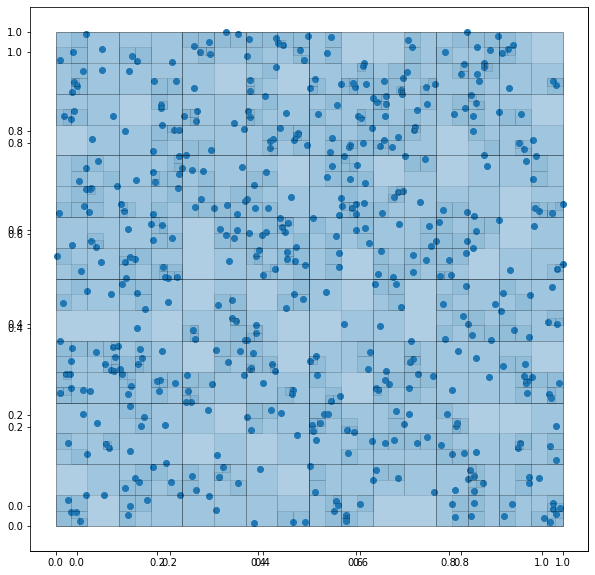

In [60]:
points = np.random.rand(500, 2)

X = points[:, 0]
Y = points[:, 1]

ax = plt.figure(figsize=(10, 10))
plt.xlim(-.1, 1.1)
plt.ylim(-.1, 1.1)

from collections import namedtuple
from collections import deque

def rolling(it, k=2):
    it = iter(it)
    q = deque(maxlen=2)
    
    for i in range(k):
        q.append(next(it))
    
    yield tuple(q)
    for v in it:
        q.append(v)
        yield(tuple(q))
        
print(list(rolling(range(5))))

class Quad(namedtuple("Quad", ("x1", "y1", "x2", "y2"))):

    @property
    def area(self):
        return self.width * self.height

    @property
    def width(self):
        return self.x2-self.x1

    @property
    def height(self):
        return self.y2-self.y1
    
    def __contains__(self, e):
        if type(e) == Quad:
            raise NotImplemented()
        
        elif len(e) == 2:
            x, y = e
            return (self.x1 <= x <= self.x2) and (self.y1 <= y <= self.y2)
    
    def to_patch(self):
        return np.array([(self.x1, self.y1), (self.x1, self.y2), (self.x2, self.y2), (self.x2, self.y1)])

    def split(self, k=4):
        lam = [i/k for i in range(k+1)]
        xs = [p*self.x2 + (1-p)*self.x1 for p in lam]
        ys = [p*self.y2 + (1-p)*self.y1 for p in lam]
        
        res = []
        for x1, x2 in rolling(xs):
            for y1, y2 in rolling(ys):
                res.append(Quad(x1, y1, x2, y2))
    
        
        return res
    
    def expand(self):
        # only works for k=3
        x1, x2 = [p*self.x2 + (1-p)*self.x1 for p in [-1, 2]]
        y1, y2 = [p*self.y2 + (1-p)*self.y1 for p in [-1, 2]]
        
        return Quad(x1, y1, x2, y2)
        

assert ((0.5, 1.5) in Quad(0, 0, 1, 1)) is False
assert ((0.5, 0.5) in Quad(0, 0, 1, 1)) is True

# print(Quad(0, 0, 1, 1).split())
print(Quad(0, 0, 1, 1).expand().area)

def build_tree(quad, points):
    if len(points) == 0:
        return []
    elif len(points) <= 1:
        return [quad]

    else:
        res = [quad]
        for q in quad.split(2):
            res.extend(build_tree(q, [p for p in points if p in q]))

        return res


bli = build_tree(Quad(0, 0, 1, 1), points)
ax = plt.axes()
for q in bli:
    ax.add_patch(plt.Polygon(q.to_patch(), alpha=0.1, ec="black"))

plt.scatter(X, Y)


In [61]:
factorissimo1_2

NameError: name 'factorissimo1_2' is not defined

# Sushi design


In [ ]:
thing = blueprint.loads("0eNqFUdtOwzAM/Rc/d1Uvg3URf4JQlLaGWbRJ5LgTY+q/43QTQkiIt5zYPhf7Cv20YGTyAuYKNASfwDxfIdGbd1P+k0tEMECCMxTg3ZxREje878gnZEGGtQDyI36AqdeXAtALCeGNaQMX65e5105T/8VRQAxJx4LPqkrVtl35UMAFzK456lNF1J5wmGyPJ3emwLlzIB4WEqu18Xv8lTiJ/SeEsPMpBpZdj5PAjV9d5V1UGczRsZMsA09b+S7F6EZ7cn7MoqIBNanwgtoSzshMI9otnTr4xC3zyCHaXwGrsqoOXd3cQlZld4dr3uFm1fw4TwFKnbbppqv3h2Nz2NePXdtU6/oFI4CZIQ==")

In [ ]:
# thing

In [ ]:
# blueprint.loads("0eNp9kEtuwzAMRO8yazmoP2kSXaUIAidmC6IyJUh0EcPQ3SPHSNFVl0Nw3gy54OomCpFFYRfwzUuC/ViQ+Et6t850DgQLVhphIP24qu9Y0T1ESqlyvh8oIhuwDHSHrfPZgERZmTbYU8wXmcZr2bT1PxiD4FNxelmzC63tut3eYIatmlO725ecgSPdtpXGvPr5ScOkxf/JTiluwa9Gv4EcvVTB9UrI57Xn8yz75wsGP8W9wY91dzg1h65+P7bNW84PRlhjWQ==")

In [ ]:
# blueprint.loads("0eNqd0d1qhDAQBeB3Oddx2cR1f/IqRcqqgx0wo8RYKpJ3b2JvFrottDeBSWbOfJANzbDQ5FkC7AZuR5lhXzbM3Mt9yHdhnQgWHMhBQe4uV446XlxBA7XBc1tM40CICiwdfcDqWCuQBA5MX3l7sb7K4hryqeH3JIVpnNPwKFmQAstzdagUVtiiPJpDlVYlqqQZ3sUbdD48dY/bOFUmU3pPJE9eYsoR4v6tGRefoaaO6hvW/Bl7+ydW/4jVT7C6zu37x9iHf1R4Jz/vHHPVp8vNXE76fC3NMcZPWl+k+g==")

In [62]:
# blueprint.loads("0eNqlVFFvozAM/i9+hmlQaLnoXu53nCoUwN2iC0nkmGpVxX+/BNYObVy33l6InNj+7M8fPkOjB3SkDIM4g2qt8SB+n8GrJyN1vOOTQxCgGHtIwMg+WvjiCL1PB9MhPZENZ9qgZhgTUOHuBUQ2Jp+m+UPpJZO2MqRaxOfjPgE0rFjhXNNknGoz9E3wFNmNNAk460OkNRE7Zqs2D2UCJxBpXuQPZcDpFGE7u+TJpT47sBs4xB+UZqQZ+NLRFbC1ziGlTktGGPex03fF5R+oYpLGO0s8E7VSYXG7wjAbJqvrBp/lUVmKca2idlBco5GNxrpTPp4gDlJ7TK7PhLKrn6Xp6pgklBr6YhoWHpf72bW3HU4TjKBmrsFHvCx+CLvlPFSwikDCuELD5nPFrBBRfmlUysRJrYAWizkZz9Jw2tq+UUayXZXG9n7il/L4IPKjIh7CzbWO2SP9BROjQ/zZ0mrxp+y/znS+aDja5T+YL9/Ae6l1qmXv1nrfve/9lszCW3cNPyjyXN/b/DwQEI/R6J2kaSgCfsbnwWPA0JZe9fl9AW7/S4DVPbsi7qlprYnFMk3gGOQxB1RZsfuR74psW23yx3H8C5DV2MI=0eNqlVFFvozAM/i9+hmlQaLnoXu53nCoUwN2iC0nkmGpVxX+/BNYObVy33l6InNj+7M8fPkOjB3SkDIM4g2qt8SB+n8GrJyN1vOOTQxCgGHtIwMg+WvjiCL1PB9MhPZENZ9qgZhgTUOHuBUQ2Jp+m+UPpJZO2MqRaxOfjPgE0rFjhXNNknGoz9E3wFNmNNAk460OkNRE7Zqs2D2UCJxBpXuQPZcDpFGE7u+TJpT47sBs4xB+UZqQZ+NLRFbC1ziGlTktGGPex03fF5R+oYpLGO0s8E7VSYXG7wjAbJqvrBp/lUVmKca2idlBco5GNxrpTPp4gDlJ7TK7PhLKrn6Xp6pgklBr6YhoWHpf72bW3HU4TjKBmrsFHvCx+CLvlPFSwikDCuELD5nPFrBBRfmlUysRJrYAWizkZz9Jw2tq+UUayXZXG9n7il/L4IPKjIh7CzbWO2SP9BROjQ/zZ0mrxp+y/znS+aDja5T+YL9/Ae6l1qmXv1nrfve/9lszCW3cNPyjyXN/b/DwQEI/R6J2kaSgCfsbnwWPA0JZe9fl9AW7/S4DVPbsi7qlprYnFMk3gGOQxB1RZsfuR74psW23yx3H8C5DV2MI=")


help(jq.first)

Help on built-in function first in module jq:

first(...)



In [63]:
input_widget = blueprint.loads("0eNrtXG1vozgQ/i98PCUrbGMbR3cfbt/+xGkV0cRt0RESAdnbapX/fibpNanxJNhTsuF2v7SCOIx5Zjx+5hnI9+iu2OpNlZdNNPse5Yt1WUezv75Hdf5QZkV7rnna6GgW5Y1eRZOozFbtkf62qXRdT5sqK+vNumqmd7poot0kysul/hbNyG7S+yJb85XqoVqb//Zl6O7LJNJlkze5Pkxsf/A0L7erO10ZO5emNIk269p8fV2282gvmbJ3fBI9RbMpTeg7bowt80ovDkPoJDIYNNW6mN/px+xrvq7a7y3yarHNm7kus7tCz5d53f6PZvdZUevJy8eVzpbzx6xcztuLmKmaOTfV9mTEf+cPQ1frpd5j1RotD3OoW3uk/VPp5ekt5+aI7b7sdi20Fgz0MqgOIJLzQPzntHKzbX3SMcpejLZh02RlM12sV3d5mTUGNYc97g/8fV40ugJi8mteNVtz5mUehxHTP6M9ots2qKfpSUx+6Y80Obnh9phbx+LoU9dwmgCeShCgsT1obwZTe9dHoEgPnB4qrUsbKQ7cKT/aW2VFMS2y1cZ1g8KOinML0Hy2fPn6fV7Vzdw3LA6oR7O4PVhtsmqP/Cz6vf14W2tjo1hXzyvXa2lO3AAldmxAiImXGS/1Ijfr90JoyNeBcXk1PV/2iGIdAGNWPjWPeflwCc1JtN42JnX0uPLf1TRr2rxopjQnhwtvnub7yJzfV+vV/JCEDvl255cvJxEFPlWAH2RQNpW9sukBE1c6TQO2MhW+lQ29kqAt8/V+6NoxrU3VtWXGHomcv87U1FqNjIILt89XnQGkAlyZXtmVrjUHOfSPW3KouOAUAjiFxP5eUfGNccXYZ2dmEAkhJCTDKYLji4R6ch/FBuM+i6es9CQ/rtwCAuzLjRUdEze+lBdTCJakHydU7P/BCYmNzEXkVPhmBLEZciTiWZU3jyvd5IsL0chBZincvjheGUcudbZ4bDGvdXuZ+dEzZoWuN9r4ZT+L6Dcfevnq2jufDNoF/RyfTG1vM/uEXQqQtLe/7Qoz7XHt1yck696MM2BE0O6QIPkv6dLuelPkhqO4Q/TEXMfYITUeCqk2hKrt/rPppsiM56tj8GwqE8BmFmZooe/d8zoS83p7Z8Jxb8Uxo2M5hkml/dc/4D2Fk8TikUliFNTEYhwQZGxAQGSEEqw6SALYHkVrknGIVYwoGQ9JvD68BfFSXZnROmEnfQ6VQxSjRJIhkXr/BkhRe+u1j2ncV5WjAUImGZS0vh+UtLZ5ZAJJvZ1oAzATWAmNhFAIilbu4iCzqX+ExINGyIdhIwTWuqkdIhzcnhVO74yvqHd+GJHeyezCkMM1pXOs01ssxkma8S9J85zPOt1GKLEygvMD+eWHc36wSQG4HCgueZErJq/3I0peVHVUDnCncQx1+4rhdP94jLq/9bACtAmzBIcNGR82HU0uhrDh2CZJSAHLBNZqSLHOJKJfcfNlM7OLYgHVeixF4HDzRXFHj2YSwkH5N2rGXPN2xPMkhoVY11j3s16xP4pjrguZvSULCZcerrFuFAm2HRFU1CcUazZIwkhYaBckfpMuSJU/PLonFkIVzikricsI97r7U8Vt0B5QIlC9BJaOrJfAwZQmcUCosQEByedJimxvOGPiEk9LFNaqCrDK4/BWQe/QD2JFn96AFSWi2zKxTtgymYT2Kk4QSKkhkfo4RFOF23pJIvvKv5x6a+bPoTQUN/o0KDfiMKHkNqwSkjI48wdNDQrax2FBI7D8k3YXKQBagmwKncvUMJHjHGtWBZkVKIHYm6n8XAIxt6MuhYgSlyiF+Dp+8Mh8N+OBjuwL5wjnWLe3UtyqUb9WzTmf2QyLgasG1xS+jh88tr6b8YDNyyjcFHaOdb+vhnuj4jaqYq/ugbCpWgrxW4F9xSKoPhQUazWkPhS4DtttiAJ+cWAXPgyMgyS8o3D7tbOwH/dJoYdQBUfgcPOVsUj6dlaE8O4JjLruFfZuknJw53GOdaMo/VEccyEsRP/+VGLnJvNlAMUU2eIIq4yFwpoNqoxlHNhZadvHA/YWJEE1Vhw+cBmhOCOqT/dGMv83zU7J++4HvVs2/TEvl6Xq+DYZ6pUfmXhFdnq1yOa4ZpEcWbMIbAtIgW3byABaLiWiGSGHpFyf34BydXoPkveV0aX/8/rPeAzFHj4Pyh4k/BgGqJpLhZWvZdCPoOCeM/dOGT+dEOf2dkpwupu8ou72eVy62xmZDfAFWsMJ2SxSpIYjx6jhAA7ASDY3v28KSKFJuX9NPeZdsS2LISECzJPYn0YI3BUlrnqTfUrENKAHpoSvkYAGj1JjTjP2r24cWpAm8vY/hjo7+QHWSVRkBgJz7p98+aDbE19NijjcZkoSqahMiEgZjXe7fwGxPlgd")
json.dumps(input_widget)

# jq.compile('(.. | objects | select(has("x")) | .x ) -= $x0')

jq.compile('(.. | objects | select(has("y")) | .y ) -= -242').input(input_widget).first()


jq.compile("""
  ((.. | objects | select(has("x")) | .x ) -= $x)
| ((.. | objects | select(has("y")) | .y ) -= $y)
| ((.. | objects | select(has("entity_number")) | .entity_number ) += $entity)
| ((.. | objects | select(has("entity_id")) | .entity_id ) += $entity)
| ((.. | objects | select(has("type")) | select(.type == "virtual") | select (.name == "signal-A") | .name ) |= "copper-plate")
| ((.. | objects | select(has("type")) | select(.type == "virtual") | select (.name == "signal-B") | .name ) |= "steel-plate")
| ((.. | objects | select(has("type")) | select(.type == "virtual") | select (.name == "signal-B") | .name ) |= "plastic")
""", args={"x": 283, "y":-242, "entity": 100}).input(input_widget).first()
# import jq
# input_widget

# jq.compile("map_values(..+1)").input(input_widget).first()

{'blueprint': {'icons': [{'signal': {'type': 'item',
     'name': 'express-transport-belt'},
    'index': 1},
   {'signal': {'type': 'item', 'name': 'express-underground-belt'},
    'index': 2}],
  'entities': [{'entity_number': 101,
    'name': 'express-transport-belt',
    'position': {'x': 0.5, 'y': -0.5},
    'direction': 2,
    'control_behavior': {'circuit_enable_disable': False,
     'circuit_read_hand_contents': True,
     'circuit_contents_read_mode': 1},
    'connections': {'1': {'red': [{'entity_id': 103}]}}},
   {'entity_number': 102,
    'name': 'express-underground-belt',
    'position': {'x': 1.5, 'y': -0.5},
    'direction': 2,
    'type': 'input'},
   {'entity_number': 103,
    'name': 'constant-combinator',
    'position': {'x': 2.5, 'y': -0.5},
    'direction': 2,
    'control_behavior': {'filters': [{'signal': {'type': 'virtual',
        'name': 'copper-plate'},
       'count': -8,
       'index': 1}]},
    'connections': {'1': {'red': [{'entity_id': 101},
       {'

In [64]:



def normalize(widget):
    def make(x, y, signals, entity_id, )






SyntaxError: invalid syntax (<ipython-input-64-fe8d1cde6c30>, line 2)